# CNN: How to find glacial lakes

Here we have some helper functions for normalizing and standardizing our data using numpy.

In [1]:
import numpy as np

def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def min_max_scale(da):
    """
    Scale training data by minimum and maximum values.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.min(da)) / (np.max(da) - np.min(da))

## **Supervised Learning**

Load images and labels from the computer.

In [2]:
import rasterio
import numpy as np
import os
from tqdm import tqdm

# Open files from the computer
dirname = '/media/mong/RAIDDATA2/Kat/Kanger_ML'
filenames = os.listdir(dirname)


label_files = [f'{dirname}/{file}' for file in filenames if file.find('label')>-1]
img_files = [f'{dirname}/{file}' for file in filenames if file.find('label')==-1]
img_files.sort()
label_files.sort()
x = np.zeros((100,100,len(img_files)),dtype='float') # change to size of image
y = np.zeros((100,100,len(label_files)),dtype='float')


# Reading the jp2s with rasterio
n = 0
for jp2 in tqdm(img_files):
    with rasterio.open(jp2) as f:
        x[:,:,n] = f.read()
        n+=1


# Open the labels
n = 0
for jp2 in tqdm(label_files):
    with rasterio.open(jp2) as f:
        y[:,:,n] = f.read()
        n+=1


  0%|          | 0/2701 [00:00<?, ?it/s]/home/mong/tools/miniconda3/envs/kat2/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
  1%|          | 15/2701 [00:00<00:35, 74.67it/s]

100%|██████████| 2701/2701 [00:40<00:00, 67.48it/s]


In [4]:
img_files[2071]

'/media/mong/RAIDDATA2/Kat/Kanger_ML/T25WDS_20170802T141949_B02_image_137.jp2'

In [5]:
label_files[2071]

'/media/mong/RAIDDATA2/Kat/Kanger_ML/T25WDS_20170802T141949_B02_label_137.jp2'

In [6]:
np.size(x)

27010000

In [7]:
np.size(y)

27010000

Now the data is loaded in, visualize it to check.

In [8]:
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

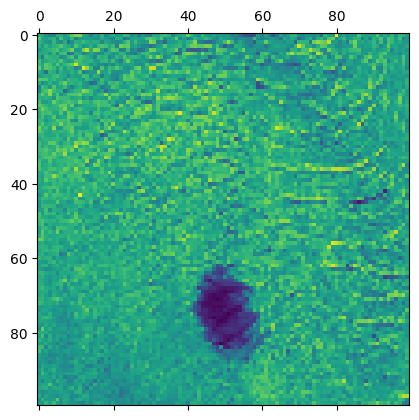

In [9]:
plt.matshow(x[:,:,2000])

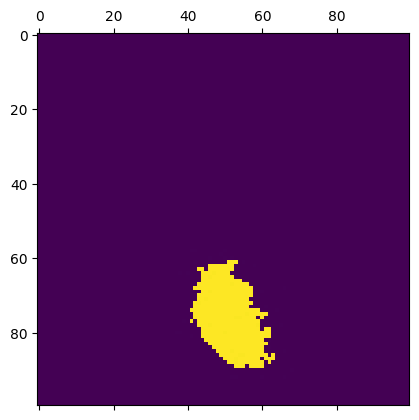

In [10]:
plt.matshow(y[:,:,2000])

Now we will preprocess our training and testing data. We need to split our data into a training and testing sets, and standardize.

In [11]:
x_rs = np.transpose(x, (2,0,1))
y_rs = np.transpose(y, (2,0,1))

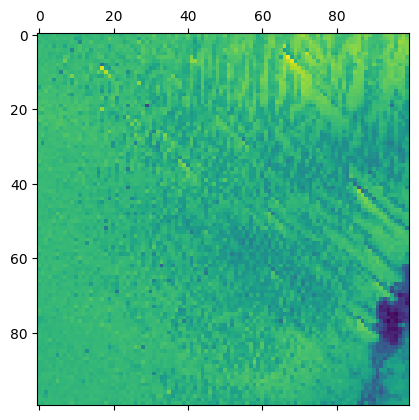

In [12]:
# Visualize
plt.matshow(x_rs[309,:,:])

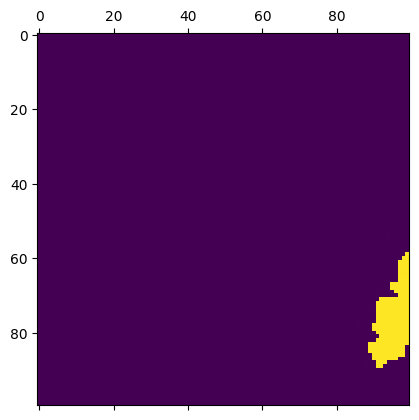

In [13]:
# Visualize
plt.matshow(y_rs[309,:,:])

Split into training and testing

In [191]:
train_feats_1, test_feats_1, train_label, test_label = sklearn.model_selection.train_test_split(x_rs,y_rs, test_size = 0.2, random_state = 1)


In [192]:
# Check the number of features in test and train
print(train_feats_1.shape[0], train_label.shape[0], test_feats_1.shape[0], test_label.shape[0])

2160 2160 541 541


In [193]:
# Need to reshape the data for the standardization step
train_feats_2 = train_feats_1.reshape(train_feats_1.shape[0], 10000) 
test_feats_2 = test_feats_1.reshape(test_feats_1.shape[0], 10000) 
print(train_feats_2.shape)

(2160, 10000)


In [194]:
# Do min-max here, transform on both but fit on train but not on test (features)
scaler = MinMaxScaler()
scaler.fit(train_feats_2)
train_feats_3 = scaler.transform(train_feats_2)
test_feats_3 = scaler.transform(test_feats_2)

In [307]:
# Reshape back to original shapes
train_feats = (train_feats_3.reshape(train_feats_1.shape[0], 100, 100) * -1) + 1
test_feats = (test_feats_3.reshape(test_feats_1.shape[0], 100, 100) * -1) + 1
print(train_feats.shape)

(2160, 100, 100)


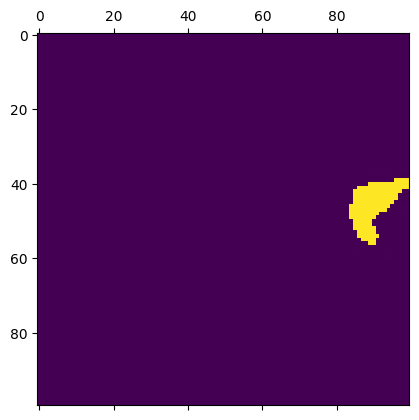

In [308]:
# Check the results
plt.matshow(train_label[310,:,:])

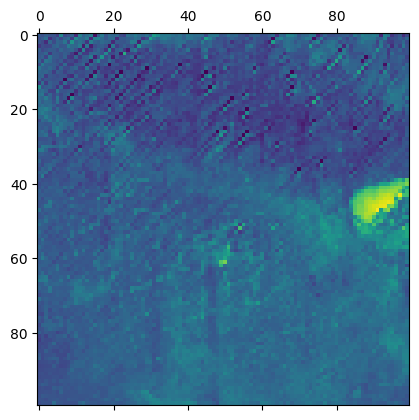

In [309]:
plt.matshow(train_feats[310,:,:])

Now construct the CNN which will take in images and identify lakes using the labels we give it.

In [310]:
import keras
from keras import layers

In [311]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

In [312]:
# lets use one input variable
number_of_features = 1

In [363]:
# Toggle this step on to re-run without reloading data or off if it's the first time running
del model

In [364]:
# Make the model
model = keras.Sequential()

# input
model.add(keras.Input(shape=(100, 100, number_of_features)))  # 100x100 images

# hidden layers
model.add(layers.Conv2D(10, 3, strides=1, padding="same", activation="relu"))
#model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(10, 3, strides=1, padding="same", activation="relu"))
#model.add(layers.Dropout(0.2))


model.add(layers.Conv2D(10, 3, strides=1, padding="same", activation="relu"))
#model.add(layers.Dropout(0.2))


# Finally, we add last fully connected (dense) layers
model.add(layers.Conv2D(1, 3, strides=1, padding="same", activation="sigmoid"))


# print model summary
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_91 (Conv2D)              │ (None, 100, 100, 10)      │        100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_92 (Conv2D)              │ (None, 100, 100, 10)      │        910 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_93 (Conv2D)              │ (None, 100, 100, 10)      │        910 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_94 (Conv2D)              │ (None, 100, 100, 1)       │         91 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,011 (7.86 KB)

 Trainable params: 2,011 (7.86 KB)

 Non-trainable params: 0 (0.00 B)

Proceeding with compiling our model and selecting some metrics to use.

Some common evaluation metrics used with regression problems are:

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$


More evalution metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [365]:
# Set up the metrics for the model 
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

In [366]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

In [367]:
# Set up the batch size (number of samples processed before model is updated)
BATCH_SIZE = 256 # best so far: 256
# Set up the epochs (number of times the model sees the full dataset)
EPOCHS = 5

In [368]:
# Train the model

history = model.fit(
    x=train_feats,
    y=train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    shuffle=True,
)

Epoch 1/5


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1127.3749 - mean_squared_error: 1127.7998 - root_mean_squared_error: 33.5819 - val_loss: 1127.6530 - val_mean_squared_error: 1121.4518 - val_root_mean_squared_error: 33.4881
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1126.8718 - mean_squared_error: 1127.2977 - root_mean_squared_error: 33.5744 - val_loss: 1126.9459 - val_mean_squared_error: 1120.7476 - val_root_mean_squared_error: 33.4776
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1126.0801 - mean_squared_error: 1126.5071 - root_mean_squared_error: 33.5626 - val_loss: 1125.9148 - val_mean_squared_error: 1119.7211 - val_root_mean_squared_error: 33.4622
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1125.0480 - mean_squared_error: 1125.4735 - root_mean_squared_error: 33.5472 - val_loss: 1125.0743 - val_mean_squared_error: 1118.8875 - val_root_mean_squared_error: 33.4498
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1124.3345 - mean_squared_error: 11

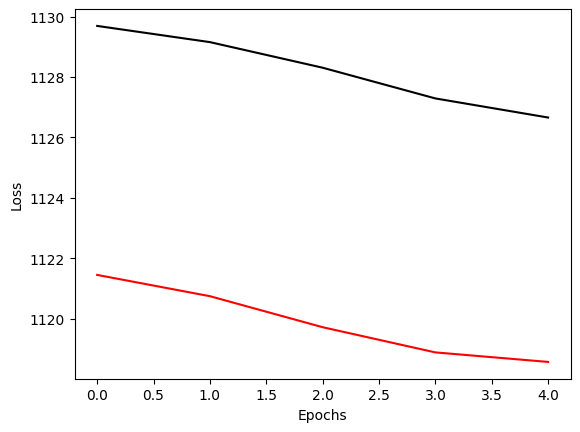

In [369]:
# Plot the learning history
fig, ax = plt.subplots()
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
ax.set(xlabel = 'Epochs', ylabel = 'Loss')
plt.show()


Lets now evaluate the model using the test dataset. We need to standardize the data, but using the mean and standard deviation of the training set.

In [370]:
# Use the model to predict using the test data 
predictions = model.predict(test_feats)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [371]:
np.shape(predictions)

(541, 100, 100, 1)

See how well the model does at predicting the label when given the image

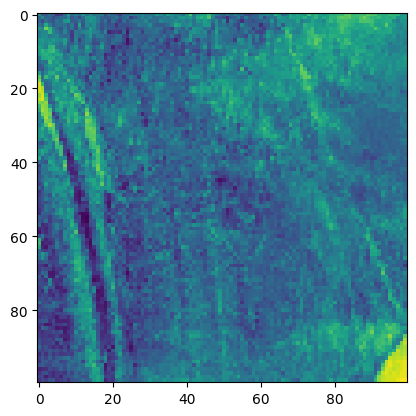

In [398]:
plt.imshow(test_feats[40,:,:])

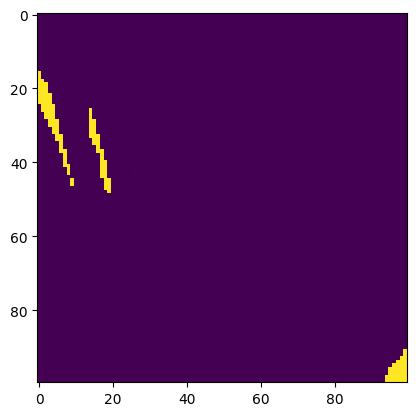

In [399]:
plt.imshow(test_label[40,:,:])

In [389]:
# Use this section to set some threshold value that is considered a lake or not
predictions_good = (predictions[:,:,:,0]>0.995) 

In [390]:
# Use this section to check if the threshold is good
print(predictions_good)

[[[False False False ... False False False]
  [False False False ...  True  True False]
  [False False False ...  True  True False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ...  True False False]
  [False False False ...  True  True False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

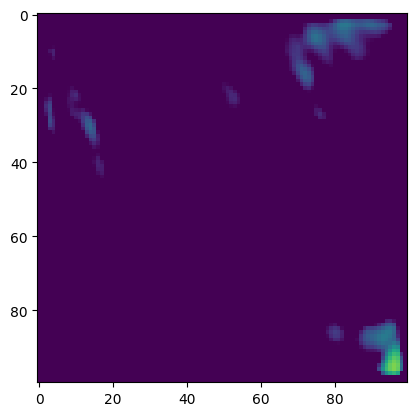

In [400]:
# Plot the prediction 
plt.imshow(predictions[40,:,:,0], vmin=0.995, vmax=1)

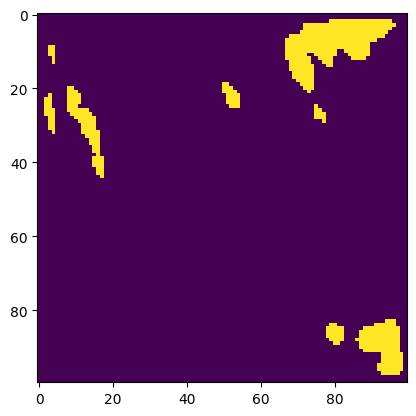

In [401]:
# Plot the prediction with thresholding
plt.imshow(predictions_good[40,:,:]) #, vmin=0, vmax=1)

In [393]:
# Check the output values
print(predictions[50,:,:,0])

[[0.6982284  0.8384661  0.8811018  ... 0.9251061  0.8967643  0.80886906]
 [0.77030665 0.9155603  0.9501754  ... 0.9780912  0.96111715 0.890414  ]
 [0.78702706 0.9352306  0.9668115  ... 0.98827624 0.976941   0.91964984]
 ...
 [0.8139395  0.94852537 0.97663814 ... 0.9683562  0.95006365 0.8733516 ]
 [0.75632626 0.90320504 0.9435291  ... 0.93233067 0.902182   0.8168414 ]
 [0.6572721  0.7639902  0.8103893  ... 0.79425544 0.748383   0.65435684]]


# References



@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Sentinel 2 Data Downloaded from: 
@Misc{,
  author =    {Planet Labs PBC},
  organization = {Planet},
  title =     {Planet Application Program Interface: In Space for Life on Earth},
  year =      {2018--},
  url = "https://api.planet.com"
}